# This is a quick notebook for exploring the mechanisms within the TSAM repository

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
# general imports
import numpy as np
import pandas as pd
import torch

from diffusers import StableDiffusionPipeline

import os
import shutil

print(torch.version.cuda)

12.1


#### TSAM imports based on run python file

In [4]:
# the following code enables imports from the folders in the repository
# NOTE: this only affects the active kernel, not actual system path
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

In [5]:
import matplotlib.pyplot as plt
import torch
import os
import torch.nn.functional as F
from typing import List


from tsam.utils import (load_model,
                       save_image,
                       save_text_sa_avg,
                       get_token_ids,
                       LatentOptConfig)

import argparse
import yaml

$$ $$

$$ $$

$$ $$

## Model load in based on run file

In [6]:
from tsam.run import run_one_prompt

In [7]:
def set_notebook_args(notebook_args):
    parser = argparse.ArgumentParser(description="Run latent optimization")
    parser.add_argument("--prompt", type=str, default='a green glasses and a yellow clock',help="Text prompt")
    parser.add_argument("--model_name", type=str, default="sd1_5x_2", help="Model name")
    parser.add_argument("--device", type=str, default="cuda", help="Device to use")
    parser.add_argument("--steps", type=int, default=10, help="# of inference steps")
    parser.add_argument("--seed", type=int, default=4913, help="Random seed")
    parser.add_argument("--generation_dir", type=str, default="./generation_dir", help="Output dir")

    if notebook_args is not None:
        return parser.parse_args(
            [f'--{k}={v}' for k, v in notebook_args.items()]
        )
    else:
        raise Exception("No notebook argument dictionary")


with open('../../tsam/configs/config.yaml','r') as f:
    config_dict = yaml.safe_load(f)
    
latent_opt_config = LatentOptConfig(**config_dict)

notebook_args = {
    'prompt' : 'a green glasses and a yellow clock'
}

args = set_notebook_args(notebook_args)




prompt_list = [args.prompt]
save_flags = {
    "save_text_selfattn": False,
    "save_gen_images": True,
    "save_crossattn_sim": False
}



pipe = load_model(model_name=args.model_name, device=args.device)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [8]:
"""
run_one_prompt(
        prompt=args.prompt,
        pipe=pipe,
        latent_opt_config=latent_opt_config,
        device=args.device,
        generation_dir=args.generation_dir,
        seed=args.seed,
        num_inference_steps=args.steps,
        save_flags=save_flags,
        model_name=args.model_name
    )
"""
print()

In [9]:
# do run_one_prompt code with reduced version
def bias_reduced_generation(prompt, biased_prompts, num_inference_steps=10):

    pipe.text_encoder.to("cuda")

    # get biased prompt embeds and stuff before adding self attention layers for normal prompt
    biased_prompt_embeds = []
    bias_eos_idx = None
    for b_prompt in biased_prompts:
        b_text_inputs = pipe.tokenizer(
            b_prompt,
            padding="max_length",
            max_length=pipe.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        
        b_text_input_ids = b_text_inputs.input_ids
        eos_idx = torch.where(b_text_input_ids==49407)[1][0].item()  

        b_text_input_ids = b_text_input_ids.to(pipe.text_encoder.device)
        
        b_prompt_embeds = pipe.text_encoder(b_text_input_ids, attention_mask=None)
        b_prompt_embeds = b_prompt_embeds[0].to("cuda")
        biased_prompt_embeds.append(b_prompt_embeds)
        
    
    _, eos_idx = get_token_ids(prompt=prompt, tokenizer=pipe.tokenizer)
    for i in range(12):
        # to get attn score for each prompt
        pipe.text_encoder.text_model.encoder.layers[i].self_attn.dummy = 0


    _, biased_eos_idx = get_token_ids(prompt=biased_prompts[0], tokenizer=pipe.tokenizer)
        
    # sd 1.5 option
    pipe.attn_fetch_x.set_processor(unet = pipe.unet)
    
    steps_to_save_attention_maps = list(range(num_inference_steps))
    
    max_iter_to_alter = latent_opt_config.max_iter_to_alter
    iterative_refinement_steps = latent_opt_config.iterative_refinement_steps
    
    if not latent_opt_config.update_latent:
        max_iter_to_alter = 0
        iterative_refinement_steps = []
    
    image, all_maps = pipe.bias_reduced_call(
        prompt=prompt,
        generator=torch.Generator("cuda").manual_seed(1234),
        num_inference_steps=num_inference_steps,
        max_iter_to_alter=max_iter_to_alter,
        steps_to_save_attention_maps=steps_to_save_attention_maps,
        latent_opt_config = latent_opt_config,

        biased_prompt_texts=biased_prompts,
        biased_prompt_embeds=biased_prompt_embeds,
        biased_eos_idx=biased_eos_idx
    )

    return image, all_maps


## Bias loss function tests

What loss function to enforce between two bias prompt cross attentions and self attentions?

- Just cross attentions:
   - Enforce similarity between concept maps:
      - sim_ca_cosine
      - sim_ca_mse
   - Enforce difference between concept maps:
      - diff_ca_cosine
      - diff_ca_mse
   - Could consider having a schedule of sim or diff thresholds to enforce overtime.
$$ $$
- Cross attentions and self attentions:
   - Enforce even cosine similarity between concept ca and concept prompt sa
      - Threshold similarity (50/50, 60/40, etc)
      - sim_ca_sa_cosine
$$ $$
- loss function details:
   - display: all or one
   - max_cnt: maximum interation count, default 30
   - block_class: block class to grab cross attentions from
   - total_map_size: total map size of desired cross attention layer (s*s)
   - balance_beta: multiplier for balance importance


Getting text self attention matrices for bias prompts
num latent channels: 4
step sizes [5.   4.97 4.95 4.92 4.9  4.87 4.85 4.82 4.8  4.77 4.74 4.72 4.69 4.66
 4.64 4.61 4.58 4.56 4.53 4.5  4.47 4.44 4.42 4.39 4.36 4.33 4.3  4.27
 4.24 4.21 4.18 4.15 4.12 4.09 4.06 4.03 4.   3.97 3.94 3.91 3.87 3.84
 3.81 3.77 3.74 3.71 3.67 3.64 3.61 3.57 3.54]
num_warmup_steps: 1
latents shape: torch.Size([1, 4, 64, 64])
steps_to_save_attention_map: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
latent_opt_config.attn_like_loss: None
max_iter_to_alter: 30
iterative_refinement_steps: []
device: cuda:0
off-loading VAE and text_encoder to CPU during latent optimization


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\brandon\anaconda3\envs\tsam\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


attn loss: 1.7890625
updated latent (step 0)
attn loss: 1.78515625
updated latent (step 1)
attn loss: 1.78515625
updated latent (step 2)
attn loss: 1.7734375
updated latent (step 3)
attn loss: 1.7626953125
updated latent (step 4)
attn loss: 1.7685546875
updated latent (step 5)
attn loss: 1.75
updated latent (step 6)
attn loss: 1.751953125
updated latent (step 7)
attn loss: 1.740234375
updated latent (step 8)
attn loss: 1.744140625
updated latent (step 9)
attn loss: 1.736328125
Starting bias iterative refinement for step: 10
A_np shape: (64, 64)


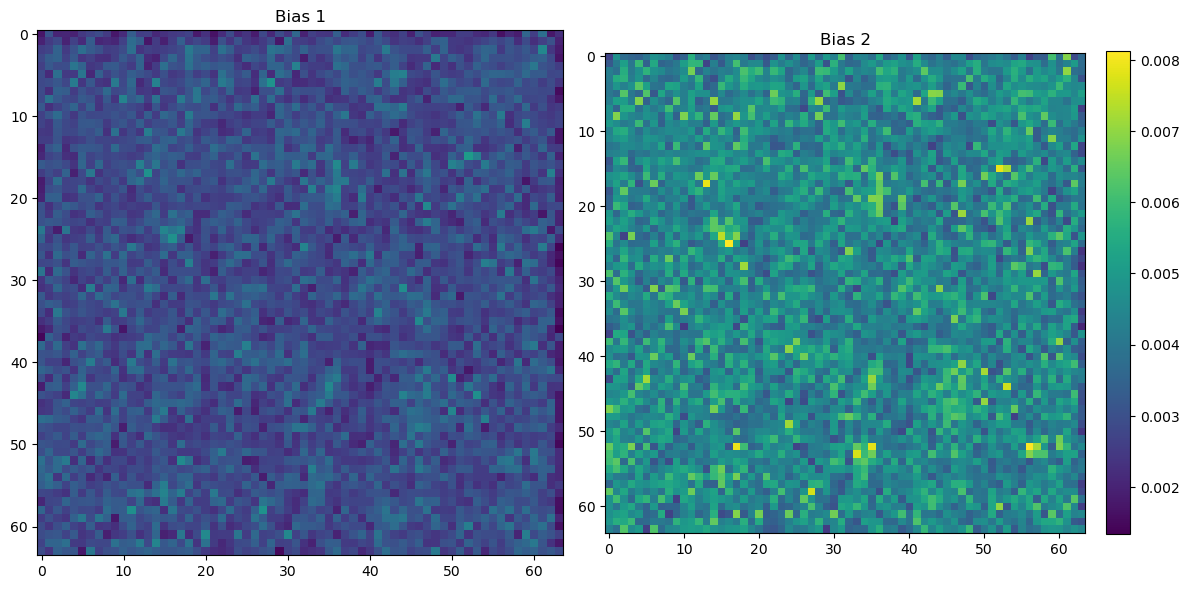

A_np shape: (32, 32)


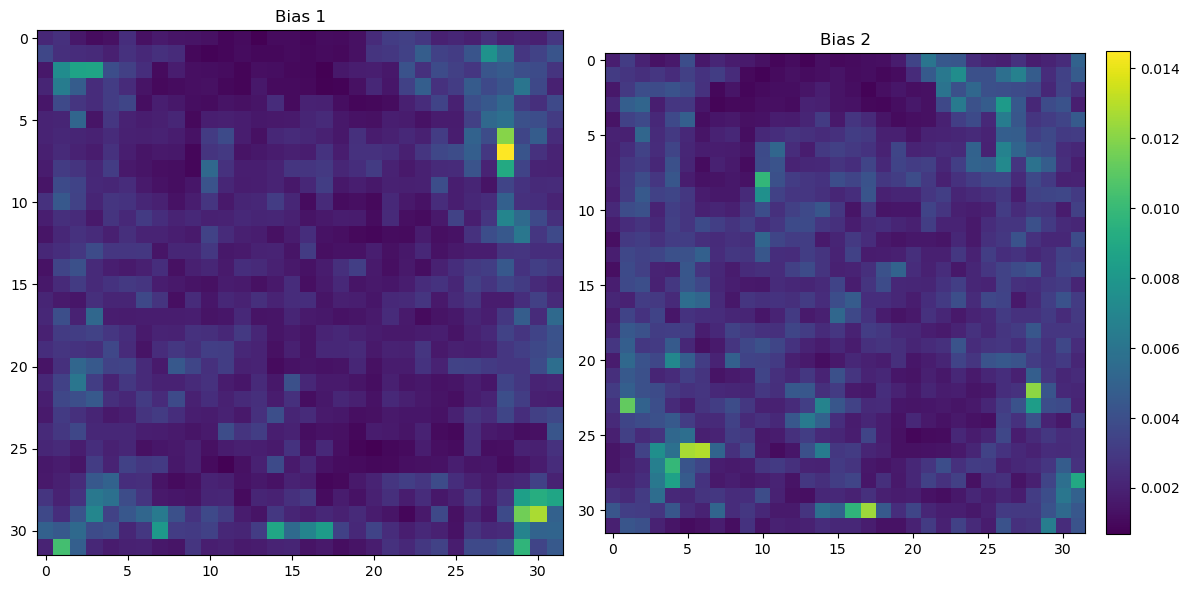

A_np shape: (16, 16)


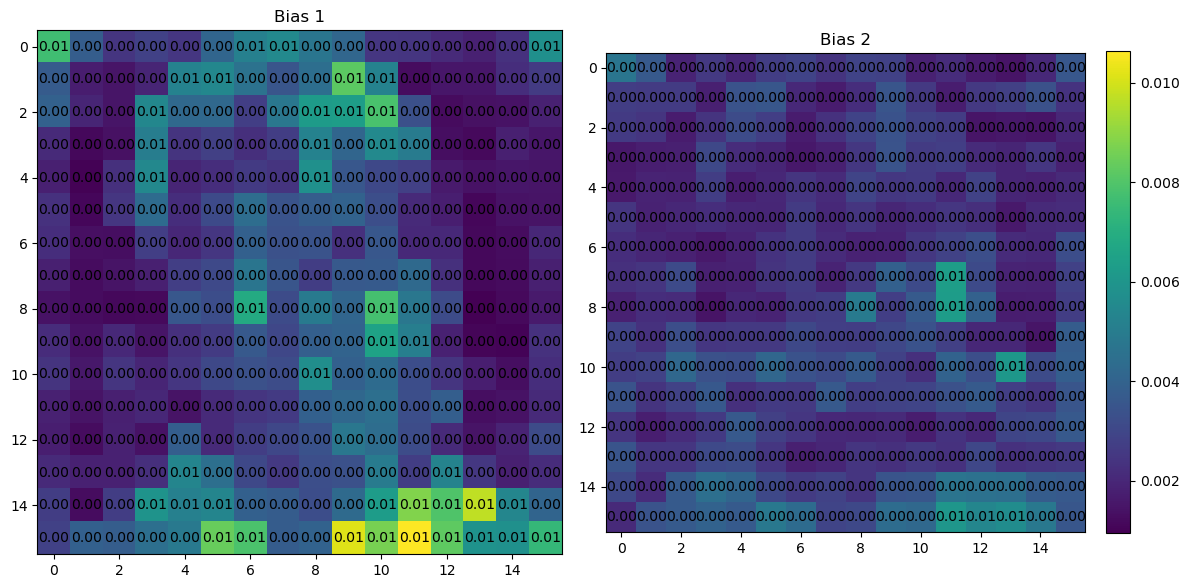

A_np shape: (16, 16)


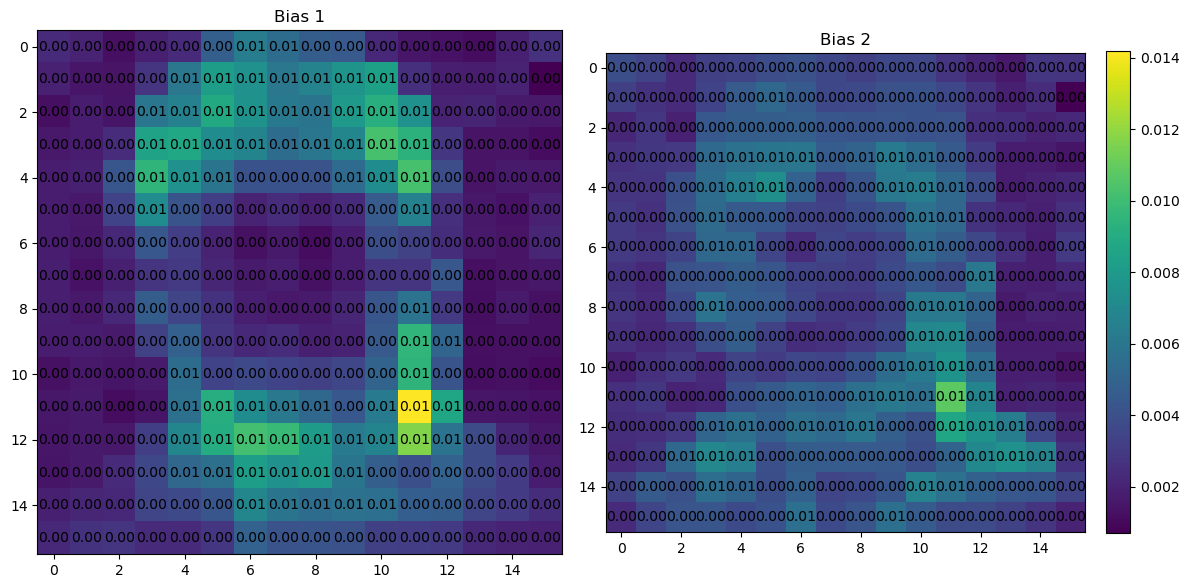

A_np shape: (32, 32)


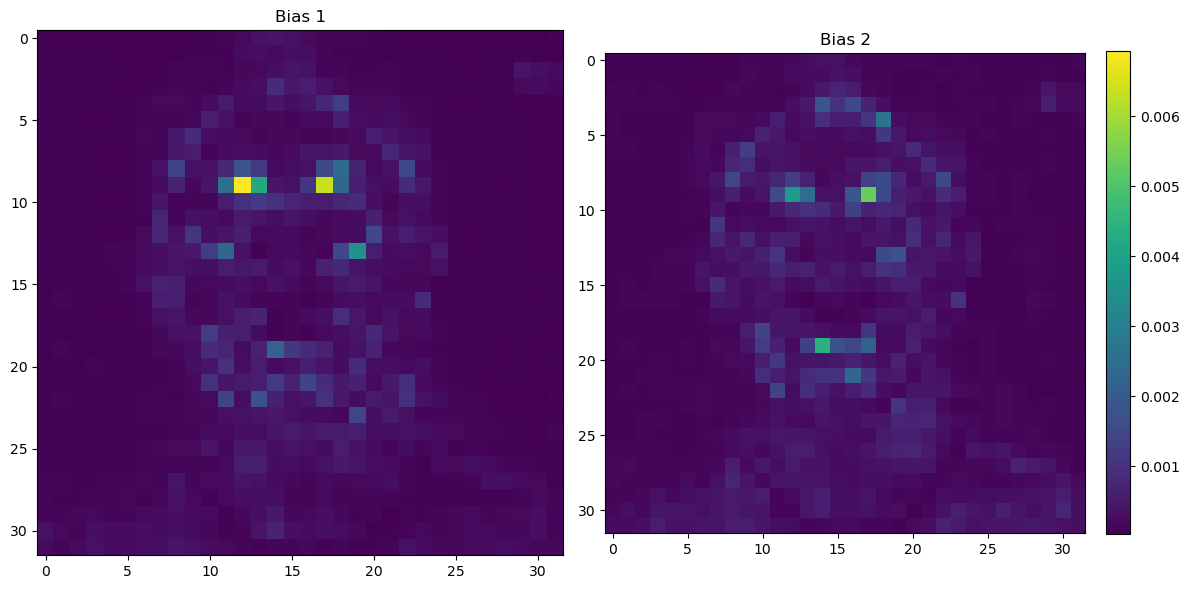

A_np shape: (64, 64)


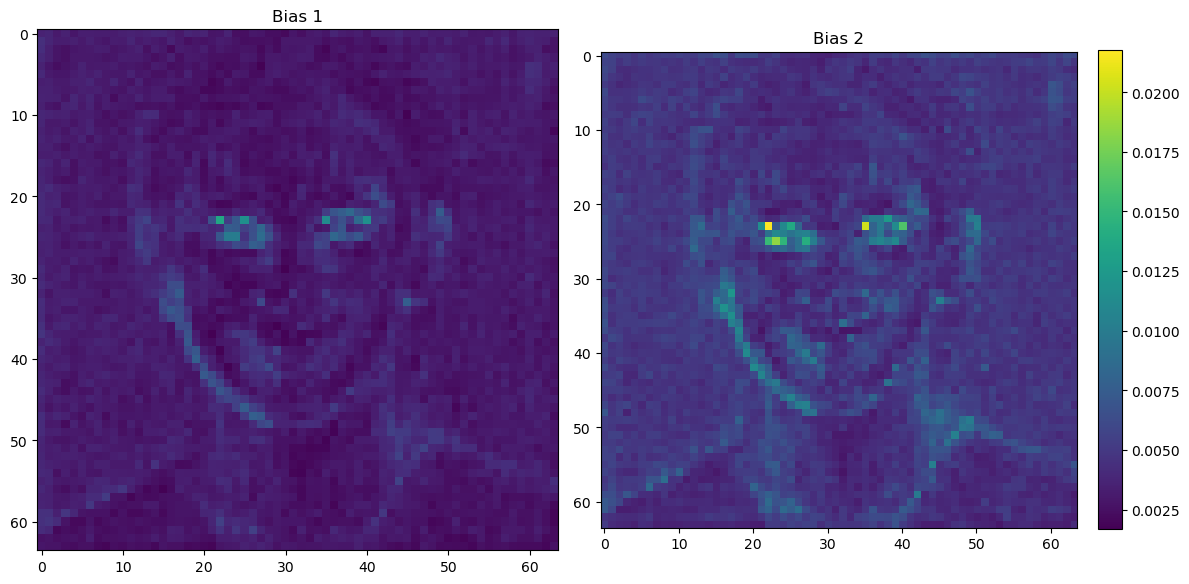

Bias concepts cosine similarity balanced loss: 3.873046875			 (avg_cos_loss, abs_diff) : (3.6875,0.185546875)


KeyboardInterrupt: 

In [10]:
# disable T-SAM iterative function
latent_opt_config.iterative_refinement_steps = []

# bias map display settings
latent_opt_config.show_first_bias_map = True
latent_opt_config.show_last_bias_map = True
latent_opt_config.show_first_bias_ca_sa = False
latent_opt_config.show_last_bias_ca_sa = False


latent_opt_config.bias_refinement_steps = [10, 20, 30, 40]

latent_opt_config.bias_loss_function = "sim_ca_sa_cosine"
latent_opt_config.bias_loss_function_details = {'display' : 'all',
                                                'block_class': None,
                                                'total_map_size': None,
                                                'balance_beta' : 0.001,
                                                'balance_beta': 5,
                                                'average_beta': 1}
latent_opt_config.bias_loss_threshold = 0.01


main_prompt = "A photo of the face of a nurse"

biased_prompts = ["A photo of the face of a nurse and male", "A photo of the face of a nurse and female"]

image, attention_maps = bias_reduced_generation(main_prompt, biased_prompts, num_inference_steps=50)

In [ ]:
plt.imshow(image[0])

In [21]:
hasattr(pipe.text_encoder.config, "use_attention_mask") and pipe.text_encoder.config.use_attention_mask

False

In [14]:
biased_prompt = "A photo of the face of a nurse and female"

In [16]:
text_inputs

{'input_ids': tensor([[49406,   320,  1125,   539,   518,  1710,   539,   320, 10058,   537,
          3970, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [15]:
image, all_maps = pipe(prompt="A photo of the face of a nurse and male" ,
                        generator=torch.Generator("cuda").manual_seed(1234),
                        num_inference_steps=10,
                        max_iter_to_alter=50,
                        iterative_refinement_steps=latent_opt_config.iterative_refinement_steps,
                        steps_to_save_attention_maps=[],
                        latent_opt_config = latent_opt_config
                    ) 

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\brandon\anaconda3\envs\CS5864\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

KeyboardInterrupt



In [5]:
pipe.scheduler

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.32.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "leading",
  "trained_betas": null
}

In [6]:
pipe.scheduler.set_timesteps(num_inference_steps=10, device="cpu")

In [7]:
pipe.scheduler.timesteps

tensor([901, 801, 801, 701, 601, 501, 401, 301, 201, 101,   1])

In [8]:
pipe.scheduler.order

1

In [8]:
pipe.unet.config.in_channels

4

In [10]:
pipe.unet.config.out_channels

4

In [12]:
pipe.vae_scale_factor

8